In [1]:
import numpy as np
import pandas as pd
import scipy.interpolate as sci
import scipy.signal as sig
from scipy.stats import f
import matplotlib.pyplot as plt

# Functions

In [23]:
def confidence_limit(x, freqs, spec, nperseg):
    """Adapted from Noah Rosenberg. """
    alpha = pd.Series(x).autocorr(lag=1)
    red_fit = (1-alpha**2)/(1-2*alpha*np.cos(freqs*np.pi*2)+ alpha**2)
    nu = 2*len(x)/nperseg
    nu_0 = len(x)*(1-alpha)/(1+alpha)
    f_crit = f.ppf(q=0.99, dfn=nu, dfd=nu_0)
    return red_fit, red_fit*f_crit


# Interpolation

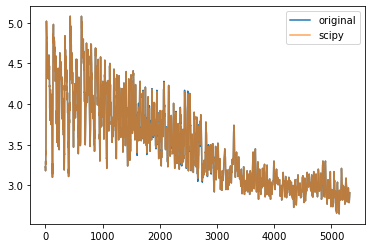

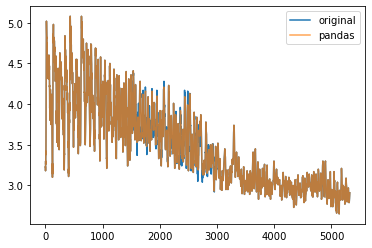

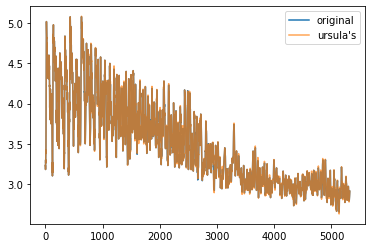

In [3]:
data_orig = pd.read_csv('Raymo_DataOnly.txt', delimiter='\s+', header=None)
x = data_orig[0].values
y = data_orig[1].values

ninds = int(x[-1])
full_years = pd.Series(np.arange(ninds+1))
xnew = full_years.values

# Method 1: scipy.interpolate.interp1d
interp_func = sci.interp1d(x, y)
scipy_interp = interp_func(xnew)

# Method 2: pandas.interpolate()
# This looks terrible compared to the others
indexed_data = data_orig.set_index(x)[1]
reindexed_data = indexed_data.reindex(full_years)
pandas_interp = reindexed_data.interpolate(method='index')


# Difference between original and scipy
plt.plot(x, y, '-', label='original')
plt.plot(xnew, scipy_interp, '-', label='scipy', alpha=.7)
plt.legend()
plt.show()

# Difference between original and pandas
plt.plot(x, y, '-', label='original')
plt.plot(pandas_interp.index, pandas_interp.values, '-', label='pandas', alpha=.7)
plt.legend()
plt.show()

# Ursula's interpolation
# NOTE: Ursula's data has 5324 values instead of 5321, not sure what got added
# This results in an offset in the data that is slightly noticeable at the end of the timeseries
data_ursula = pd.read_csv('Raymo_d18Ointerp.csv')
plt.plot(x, y, label='original')
plt.plot(data_ursula['kyr'], data_ursula['d18O_interp'], label="ursula's", alpha=.7)
plt.legend()
plt.show()

Based on these results, I'm going to use the scipy-interpolated data for my analysis.

In [4]:
data = scipy_interp

# Spectral Analysis

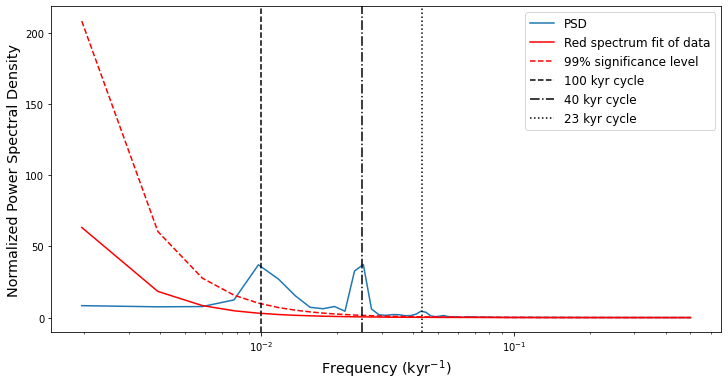

In [201]:
n = 512
n2 = n/2
freqs, pxx = sig.welch(data, nperseg=n)
pxx = pxx / np.mean(pxx)

# Fit red spectrum
alpha = pd.Series(data).autocorr(lag=1)
red_spec, red_99 = confidence_limit(data, freqs, pxx, nperseg=n)

# Identify peaks
p1 = 1/100
p2 = 1/40
p3 = 1/23

fig = plt.figure(figsize=(12, 6))
plt.semilogx(freqs[1:], pxx[1:], label='PSD')
plt.plot(freqs[1:], red_spec[1:], label='Red spectrum fit of data', c='r')
plt.plot(freqs[1:], red_99[1:], label='99% significance level', ls='--', c='r')
plt.axvline(p1, c='k', ls='--', label='100 kyr cycle')
plt.axvline(p2, c='k', ls='-.', label='40 kyr cycle')
plt.axvline(p3, c='k', ls=':', label='23 kyr cycle')
# plt.xlabel('Period (years)', size='x-large')
plt.xlabel('Frequency (kyr$^{-1}$)', size='x-large')
plt.ylabel('Normalized Power Spectral Density', size='x-large')
plt.legend(fontsize='large')
plt.show()

# Filtering

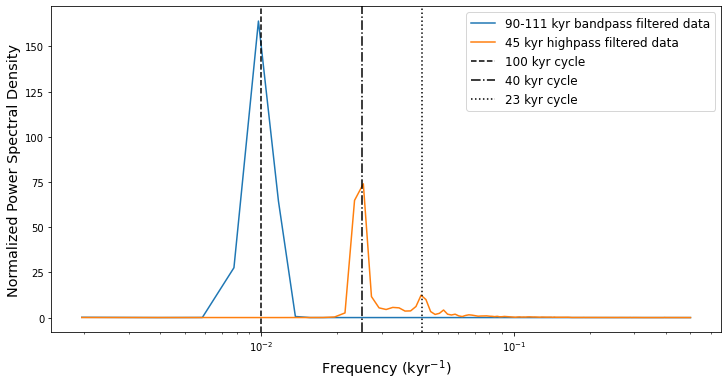

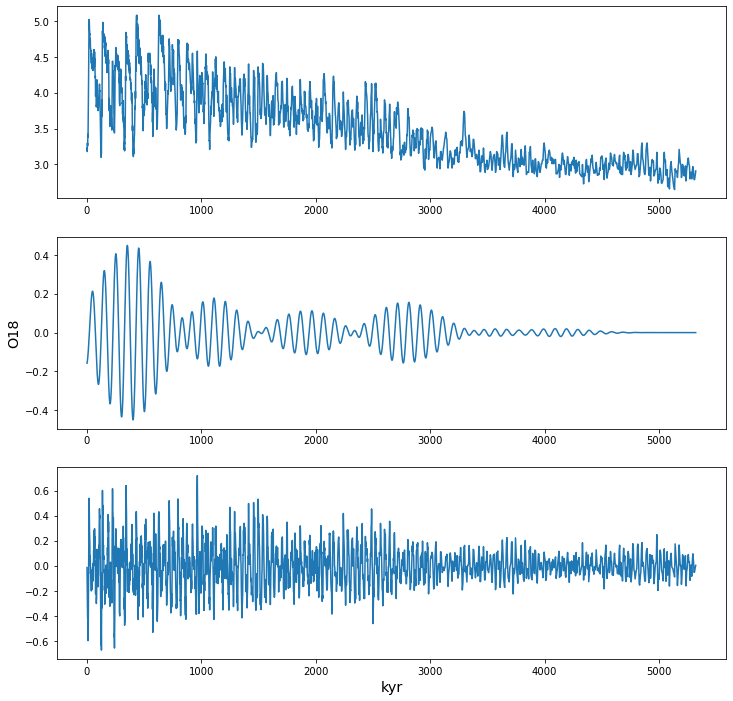

In [216]:
def filter_data(x, N, Wn, btype):
    Wn = [2*w for w in Wn]  # now as fraction of nyquist frequency
    sos = sig.butter(N, Wn, btype=btype, output='sos')
    filtered = sig.sosfiltfilt(sos, x)
    return filtered

nfilters = 2
N = 9
bandwidth = 1/100 * 0.1
upper = 1/100 + bandwidth
lower = 1/100 - bandwidth
hundred = filter_data(data, N, [lower, upper], btype='bandpass')
forty = filter_data(data, N, [1/45], btype='highpass')

freqs100, pxx100 = sig.welch(hundred, nperseg=n, window='hamming')
freqs40, pxx40 = sig.welch(forty, nperseg=n, window='hamming')
pxx100 = pxx100 / np.mean(pxx100)
pxx40 = pxx40 / np.mean(pxx40)

fig = plt.figure(figsize=(12, 6))
plt.semilogx(freqs100[1:], pxx100[1:], label=f'{int(upper**-1)}-{int(lower**-1)} kyr bandpass filtered data')
plt.semilogx(freqs40[1:], pxx40[1:], label='45 kyr highpass filtered data')
plt.axvline(p1, c='k', ls='--', label='100 kyr cycle')
plt.axvline(p2, c='k', ls='-.', label='40 kyr cycle')
plt.axvline(p3, c='k', ls=':', label='23 kyr cycle')
plt.xlabel('Frequency (kyr$^{-1}$)', size='x-large')
plt.ylabel('Normalized Power Spectral Density', size='x-large')
plt.legend(fontsize='large')
plt.show()

fig, ax = plt.subplots(3, figsize=(12, 12),sharex=False)
ax[0].plot(data)
ax[1].plot(hundred)
ax[1].set_ylabel('O18', size='x-large')
ax[2].plot(forty)
plt.xlabel('kyr', size='x-large')
plt.show()